# Notebook containing all visualizations represented in the report

### Import the required packages

In [3]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Visualize average number of published articles for the guardian and skynews respectively

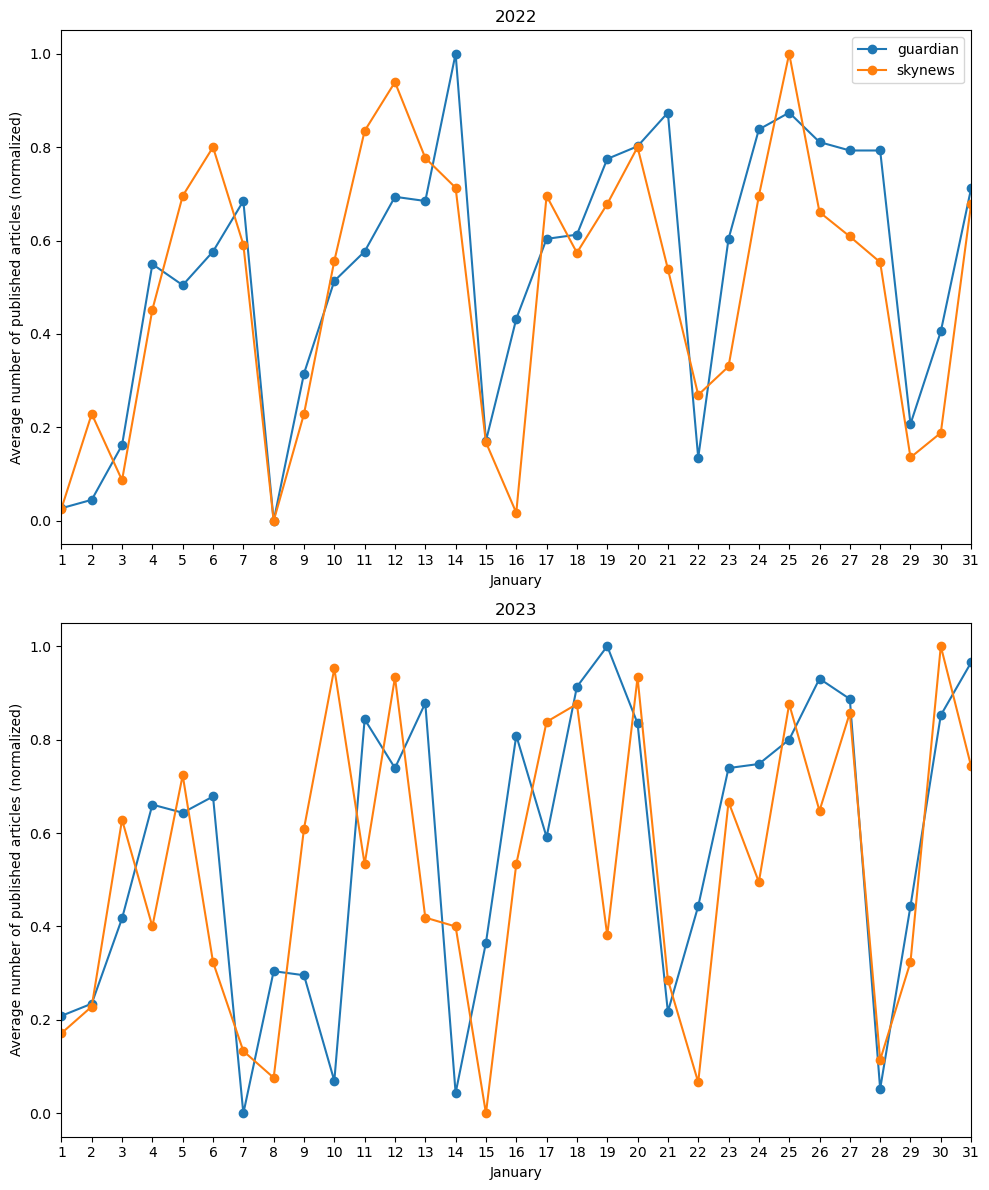

In [2]:
def plot_normalized_average(filename, ax, legend=False):
    # Load the CSV file
    df = pd.read_csv(filename, sep=";")

    # Convert 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Extract day from 'Date'
    df['Day'] = df['Date'].dt.day


    # Group by 'Day', 'Category', and 'Source' and calculate count of articles
    df_grouped = df.groupby(['Day', 'Category', 'Source']).size().reset_index(name='Article Count')

    # Calculate average article count for each day and source
    df_average = df_grouped.groupby(['Day', 'Source'])['Article Count'].mean().unstack()

    # Initialize scaler
    scaler = MinMaxScaler()

    # Normalize average article count for each source
    df_average_normalized = pd.DataFrame(scaler.fit_transform(df_average), 
                                         index=df_average.index, 
                                         columns=df_average.columns)

    # Plot normalized average article count for each source
    for source in df_average_normalized.columns:
        ax.plot(df_average_normalized[source], label=source, marker='o')

    # Set x-axis limits
    ax.set_xlim(df_average_normalized.index.min(), df_average_normalized.index.max())

    # Set x-axis labels
    ax.set_xticks(df_average_normalized.index)

    # Extract year from filename
    year = filename.split('/')[-1].split('_')[0]

    ax.set_title(year)
    ax.set_xlabel('January')
    ax.set_ylabel('Average number of published articles (normalized)')
    if legend:
        ax.legend()

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Plot data for each file
plot_normalized_average('../../data/processed/articles/2022_articles_processed.csv', axs[0], True)
plot_normalized_average('../../data/processed/articles/2023_articles_processed.csv', axs[1])

plt.tight_layout()
plt.show()

### Visualize the frequency of the top 10 keywords for both years

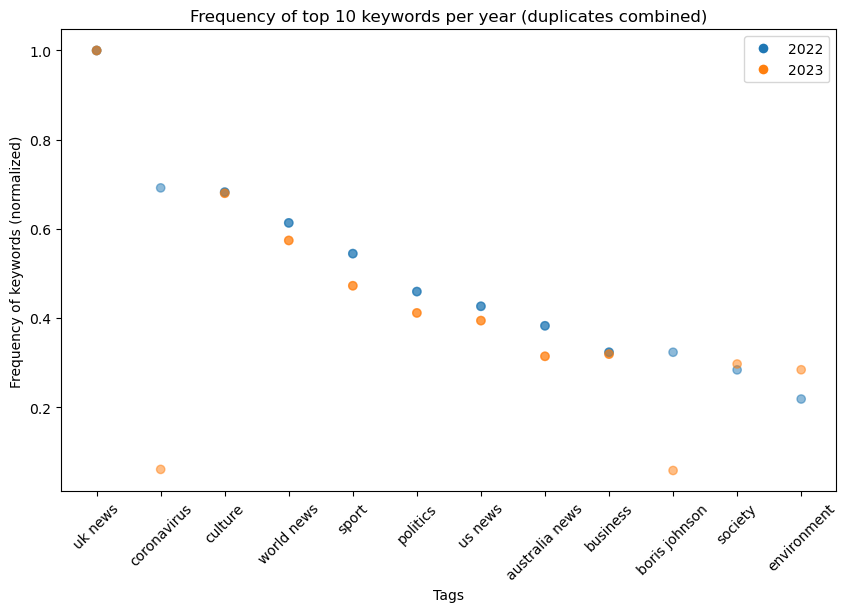

In [4]:
# Load the CSV files
df_2022 = pd.read_csv('../../data/processed/articles/2022_articles_processed.csv', sep=";")
df_2023 = pd.read_csv('../../data/processed/articles/2023_articles_processed.csv', sep=";")

# Convert the string representation of the list to an actual list
df_2022['Tags'] = df_2022['Tags'].apply(ast.literal_eval)
df_2023['Tags'] = df_2023['Tags'].apply(ast.literal_eval)

# Separate the keywords into individual rows
tag_freq_2022 = df_2022.explode('Tags')
tag_freq_2023 = df_2023.explode('Tags')

# Count the frequency of each keyword
keyword_counts_2022 = tag_freq_2022['Tags'].value_counts()
keyword_counts_2023 = tag_freq_2023['Tags'].value_counts()

# Select the top 5 keywords for 2022 and 2023
top_5_keywords_2022 = keyword_counts_2022.nlargest(10).index.tolist()
top_5_keywords_2023 = keyword_counts_2023.nlargest(10).index.tolist()

# Concatenate the two lists
top_keywords = top_5_keywords_2022 + top_5_keywords_2023

# Normalize the y-values
max_count_2022 = keyword_counts_2022.max()
max_count_2023 = keyword_counts_2023.max()

normalized_counts_2022 = keyword_counts_2022 / max_count_2022
normalized_counts_2023 = keyword_counts_2023 / max_count_2023

# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each year
colors = {'2022': '#1f77b4', '2023': '#ff7f0e'}

# Plot the frequency of each of the top 5 tags for 2022 and 2023 with normalized y-values
for keyword in top_keywords:
    ax.scatter([keyword] * 2, [normalized_counts_2022.get(keyword, 0), normalized_counts_2023.get(keyword, 0)],
               color=list(colors.values()), alpha=0.5)
ax.set_title('Frequency of top 10 keywords per year (duplicates combined)')
ax.set_xlabel('Tags')
ax.set_ylabel('Frequency of keywords (normalized)')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=v, markersize=8) for v in colors.values()]
ax.legend(handles, colors.keys())

plt.show()


### Visualize the relationship between frequency of articles and popularity

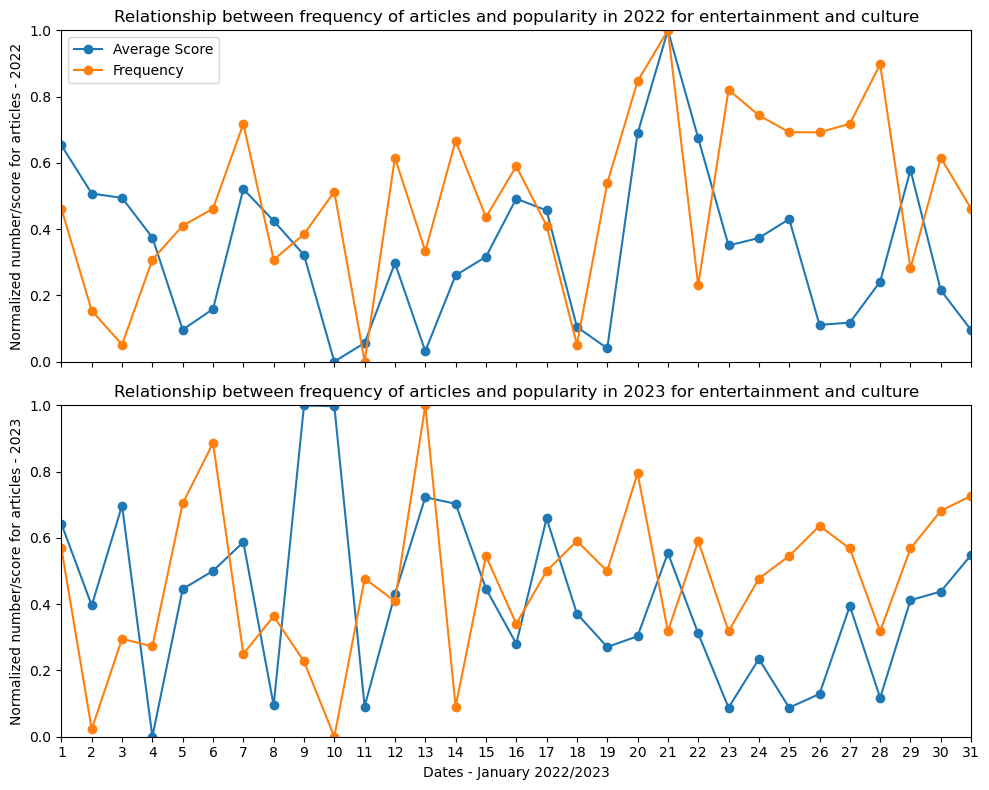

In [5]:
# Load the CSV files for 2022 and 2023
df_2022 = pd.read_csv('../../data/processed/articles/2022_articles_processed.csv', sep=';')
df_2023 = pd.read_csv('../../data/processed/articles/2023_articles_processed.csv', sep=';')

# Convert the 'Date' column to datetime for both datasets
df_2022['Date'] = pd.to_datetime(df_2022['Date'])
df_2023['Date'] = pd.to_datetime(df_2023['Date'])

# Filter the DataFrame for the specific category for both years
category = "entertainment and culture"  # Set the category to filter for here
df_categorized_2022 = df_2022[df_2022['Category'] == category]
df_categorized_2023 = df_2023[df_2023['Category'] == category]

# Group by the 'Date' column and calculate the average score for both years
df_score_2022 = df_categorized_2022.groupby(df_categorized_2022['Date'].dt.strftime('%m-%d'))['Average Score'].mean().reset_index()
df_score_2023 = df_categorized_2023.groupby(df_categorized_2023['Date'].dt.strftime('%m-%d'))['Average Score'].mean().reset_index()

# Group by the 'Date' column and count the frequency for both years
df_freq_2022 = df_categorized_2022.groupby(df_categorized_2022['Date'].dt.strftime('%m-%d')).size().reset_index(name='Frequency')
df_freq_2023 = df_categorized_2023.groupby(df_categorized_2023['Date'].dt.strftime('%m-%d')).size().reset_index(name='Frequency')

# Normalize the values for avg_score and frequency on a scale from 0-100 for both years
def min_max_scaling(x, min_val, max_val):
    return ((x - min_val) / (max_val - min_val)) * 100

frequency_column = 'Frequency'
avg_column = "Average Score"

df_freq_2022[frequency_column + '_normalized'] = min_max_scaling(df_freq_2022[frequency_column], df_freq_2022[frequency_column].min(), df_freq_2022[frequency_column].max())
df_score_2022[avg_column + '_normalized'] = min_max_scaling(df_score_2022[avg_column], df_score_2022[avg_column].min(), df_score_2022[avg_column].max())

df_freq_2023[frequency_column + '_normalized'] = min_max_scaling(df_freq_2023[frequency_column], df_freq_2023[frequency_column].min(), df_freq_2023[frequency_column].max())
df_score_2023[avg_column + '_normalized'] = min_max_scaling(df_score_2023[avg_column], df_score_2023[avg_column].min(), df_score_2023[avg_column].max())
# Plotting for each year separately
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 2022 data with markers for each day
axs[0].plot(df_score_2022.index, df_score_2022['Average Score_normalized'] / 100, label='Average Score', marker='o')
axs[0].plot(df_freq_2022.index, df_freq_2022['Frequency_normalized'] / 100, label='Frequency', marker='o')
axs[0].set_ylabel("Normalized number/score for articles - 2022")
axs[0].set_title("Relationship between frequency of articles and popularity in 2022 for " + category)
axs[0].legend()

# Set x-tick labels as indicators for days
days_2022 = df_score_2022['Date'].apply(lambda x: int(x.split('-')[1])).tolist()
axs[0].set_xticks(df_score_2022.index)
axs[0].set_xticklabels(days_2022)

# Adjust x-axis limits to remove extra space
axs[0].set_xlim([df_score_2022.index.min(), df_score_2022.index.max()])

# Set y-axis limits to display a range between 0 and 1
axs[0].set_ylim(0, 1)

# Plot 2023 data with markers for each day
axs[1].plot(df_score_2023.index, df_score_2023['Average Score_normalized'] / 100, label='Average Score - 2023', marker='o')
axs[1].plot(df_freq_2023.index, df_freq_2023['Frequency_normalized'] / 100, label='Frequency - 2023', marker='o')
axs[1].set_ylabel("Normalized number/score for articles - 2023")
axs[1].set_title("Relationship between frequency of articles and popularity in 2023 for " + category)

# Set x-tick labels as indicators for days
days_2023 = df_score_2023['Date'].apply(lambda x: int(x.split('-')[1])).tolist()
axs[1].set_xticks(df_score_2023.index)
axs[1].set_xticklabels(days_2023)

# Adjust x-axis limits to remove extra space
axs[1].set_xlim([df_score_2023.index.min(), df_score_2023.index.max()])

# Set y-axis limits to display a range between 0 and 1
axs[1].set_ylim(0, 1)
axs[1].set_xlabel(f"Dates - January 2022/2023")
plt.tight_layout()
plt.show()

### Visualize the article count per category for both years

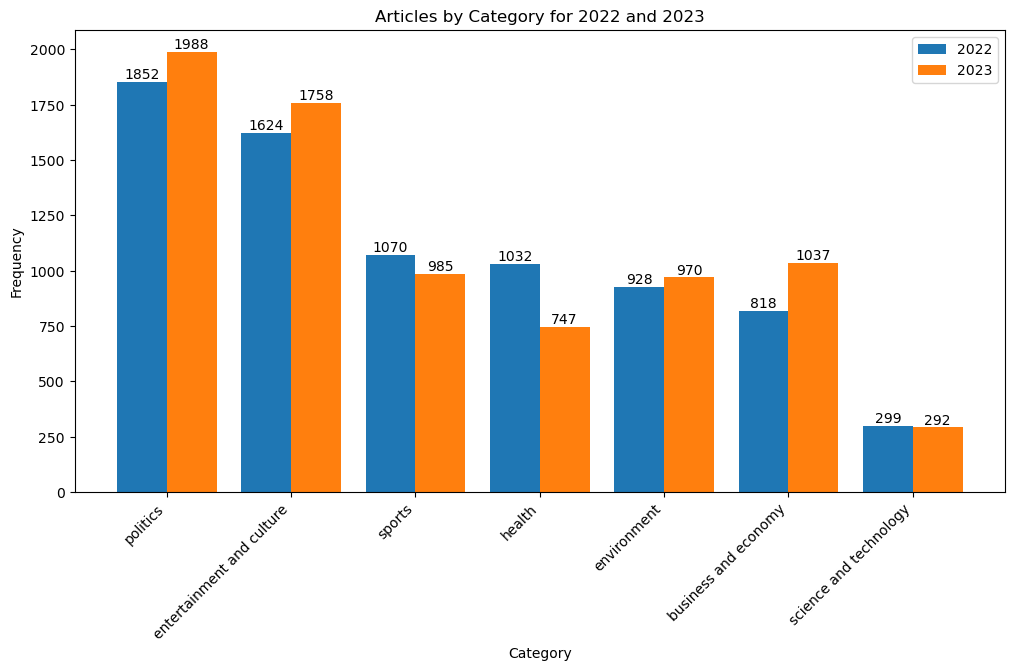

In [6]:
# Load the CSV files
df_2022 = pd.read_csv('../../data/processed/articles/2022_articles_processed.csv', sep=";")
df_2023 = pd.read_csv('../../data/processed/articles/2023_articles_processed.csv', sep=";")

# Count the frequency of each category in 2022 and 2023
category_counts_2022 = df_2022['Category'].value_counts()
category_counts_2023 = df_2023['Category'].value_counts()

# Get unique categories and their positions, ordered by count in 2022
categories = category_counts_2022.index
positions = np.arange(len(categories))

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bar chart for 2022
ax.bar(positions - 0.2, category_counts_2022.reindex(categories, fill_value=0), width=0.4, label='2022')
# Plot the bar chart for 2023
ax.bar(positions + 0.2, category_counts_2023.reindex(categories, fill_value=0), width=0.4, label='2023')

# Set x-axis ticks and labels with 45-degree rotation
ax.set_xticks(positions)
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.set_xlabel('Category')
ax.set_ylabel('Frequency')
ax.set_title('Articles by Category for 2022 and 2023')
ax.legend()

# Add data labels on top of each bar
for i, val in enumerate(categories):
    ax.text(positions[i] - 0.2, category_counts_2022.get(val, 0) + 0.5, category_counts_2022.get(val, 0), ha='center', va='bottom')
    ax.text(positions[i] + 0.2, category_counts_2023.get(val, 0) + 0.5, category_counts_2023.get(val, 0), ha='center', va='bottom')

# Show the plot

### Calculate the Pearson correlation coefficient with lag 0, 1 and 2

In [7]:
# Load the CSV file
df = pd.read_csv('../../data/processed/articles/2023_articles_processed.csv', sep=';') # change the year of the dataset to get the data from the other year

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

unique_categories = df['Category'].unique()

correlation_data = []

for category in unique_categories:
    df_categorized = df[df['Category'] == category]
    df_score = df_categorized.groupby(df_categorized['Date'])['Average Score'].mean().reset_index()
    df_freq = df_categorized.groupby(df_categorized['Date']).size().reset_index(name='Frequency')
    
    # normalize the values for avg_score and frequency on a scale from 0-100
    def min_max_scaling(x, min_val, max_val):
        return ((x - min_val) / (max_val - min_val)) * 100
    
    frequency_column = 'Frequency'
    avg_column = "Average Score"
    
    df_freq[frequency_column + '_normalized'] = min_max_scaling(df_freq[frequency_column], df_freq[frequency_column].min(), df_freq[frequency_column].max())
    df_score[avg_column + '_normalized'] = min_max_scaling(df_score[avg_column], df_score[avg_column].min(), df_score[avg_column].max())

    merged_df = pd.merge(df_score, df_freq, on='Date')
    
    for lag in range(0, 3):  # set lag values
        merged_df['Frequency_normalized_shifted'] = merged_df['Frequency_normalized'].shift(lag)
        
        # Drop rows with NaN values after shifting
        merged_df.dropna(subset=['Frequency_normalized_shifted'], inplace=True)
        
        # Calculate delayed correlation if enough data points are available
        if len(merged_df) > 1:  # Ensure enough non-null data points for correlation calculation
            correlation_delayed = merged_df['Average Score_normalized'].corr(merged_df['Frequency_normalized_shifted'])
            correlation_data.append({'Category': category, 'Lag': lag, 'Correlation': correlation_delayed})
        else:
            correlation_data.append({'Category': category, 'Lag': lag, 'Correlation': None})

correlation_df = pd.DataFrame(correlation_data)
correlation_df

,Category,Lag,Correlation
0,entertainment and culture,0,-0.141297
1,entertainment and culture,1,0.073641
2,entertainment and culture,2,0.003808
3,science and technology,0,0.164128
4,science and technology,1,-0.128956
5,science and technology,2,-0.243623
6,business and economy,0,0.322985
7,business and economy,1,0.023133
8,business and economy,2,-0.428648
9,politics,0,0.181802
